# Monge gap

In [1]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
%load_ext autoreload
%autoreload 2
%pip uninstall -y ott-jax
!{sys.executable} -m pip install -e ../../../
import dataclasses
from types import MappingProxyType
from typing import Any, Dict, Iterator, Literal, Mapping, Optional, Tuple, Union

import jax
import jax.numpy as jnp
import optax

%pip install scikit-learn
import sklearn.datasets
from flax import linen as nn

from matplotlib import pyplot as plt

from ott.geometry import costs, pointcloud
from ott.problems.nn import dataset
from ott.solvers.linear import acceleration
from ott.solvers.nn import losses, models
from ott.tools import map_estimator, sinkhorn_divergence

Found existing installation: ott-jax 0.4.3.dev12+g7d712cc.d20230814
Uninstalling ott-jax-0.4.3.dev12+g7d712cc.d20230814:
  Successfully uninstalled ott-jax-0.4.3.dev12+g7d712cc.d20230814
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/marcocuturi/VS13/ott
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ott-jax (pyproject.toml) ... done
  Created wheel for ott-jax: filename=ott_jax-0.4.3.dev12+g7d712cc.d20230814-0.editable-py3-none-any.whl size=12685 sha256=7e8f222f3bdde55ee7a1e1b86ff554b37cd451e51afa2c51d6a2472b4d3151b2
  Stored in directory: /private/var/folders/xv/6qz2dpps43777hjnwhj2c9qm0000gn/T/pip-ephem-wheel-cache-nnvlvktg/wheels/00/18/b5/77f2d03eeebccb6f346a2d8e52ff96fabe49104518899b2f2c
Successfully built ott-jax


## Description of the method

We seek to learn an optimal transport (Monge) map $T^\star$ between two probability measures $\mu, \nu$ in $\mathbb{R}^d$, w.r.t. a cost function $c : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$, namely:

$$
T^\star \in \arg\min_{\substack{T:\mathbb{R}^d \rightarrow \mathbb{R}^d \\ T \sharp \mu = \nu}} \int c(x,T(x)) \mathrm{d}\mu(x)
$$

We show how to use the {func}`~ott.solvers.nn.losses.monge_gap`, a regularizer proposed by {cite}`uscidda:23` to do so. Computing an OT map can be split into two goals: move mass efficiently from $\mu$ to $T\sharp\mu$ (this is the objective), while, at the same time, making sure $T\sharp\mu$ ``lands'' on $\nu$ (the constraint).

The first requirement (efficiency) can be quantified with the **Monge gap** $\mathcal{M}_\mu^c$, a nonnegative regularizer defined through $\mu$ and $c$, and which takes as an argument any map $T : \mathbb{R}^d \rightarrow \mathbb{R}^d$. The value $\mathcal{M}_\mu^c(T)$ quantifies how $T$ moves mass efficiently between $\mu$ and $T \sharp \mu$, and only cancels $\mathcal{M}_\mu^c(T) = 0$ i.f.f. $T$ is optimal between $\mu$ and $T \sharp \mu$ for the cost $c$.

The second requirement (landing on $\nu$) is then simply handled using a fitting loss $\Delta$ between $T \sharp \mu$ and $\nu$. This can be measured, e.g., using a {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence`. Introducing a regularization strength $\lambda_\mathrm{MG} > 0$, looking for a Monge map can be reformulated as:

$$
T^\star \in \arg\min_{T:\mathbb{R}^d \rightarrow \mathbb{R}^d} \Delta(T\sharp \mu, \nu) + \lambda_\mathrm{MG} \mathcal{M}_\mu^c(T)
$$

We parameterize maps $T$ as neural networks $\{T_\theta\}_{\theta \in \mathbb{R}^d}$, using the {class}`~ott.tools.map_estimator.MapEstimator` solver. For the squared-Euclidean cost, this method provides a simple alternative to the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` solver, but one that does not require parameterizing networks as gradients of convex functions.

## Generate data

We generate some simple datasets

In [16]:
@dataclasses.dataclass
class SklearnDistribution:
    """A class to define toy probability 2-dimensional distributions.

    Produces rotated ``moons`` and ``s_curve`` sklearn datasets, using
    ``theta_rotation``.
    """

    name: Literal["moon", "s_curve"]
    theta_rotation: float = 0.0
    mean: Optional[jnp.ndarray] = None
    noise: float = 0.01
    scale: float = 1.0
    batch_size: int = 1024
    rng: Optional[jax.random.PRNGKeyArray] = (None,)

    def __iter__(self) -> Iterator[jnp.ndarray]:
        """Random sample generator from Gaussian mixture.

        Returns:
        A generator of samples from the Gaussian mixture.
        """
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = jax.random.PRNGKey(0) if self.rng is None else self.rng

        # define rotation matrix tp rotate samples
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=(self.batch_size, 0),
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                X, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = X[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            mean = jnp.zeros(2) if self.mean is None else self.mean
            samples = mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = 512,
    valid_batch_size: int = 512,
    rng: Optional[jax.random.PRNGKeyArray] = None,
) -> Tuple[dataset.Dataset, dataset.Dataset, int]:
    """Samplers from ``SklearnDistribution``."""
    rng = jax.random.PRNGKey(0) if rng is None else rng
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = dataset.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = dataset.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data

We also define a plot function to display results

In [17]:
def plot(
    batch: Dict[str, Any],
    num_points: Optional[int] = None,
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (10, 8),
    rng: Optional[jax.random.PRNGKeyArray] = None,
):
    """
    Plot samples from the source and target measures.
    If source samples mapped by the fitted map are provided in ``batch``,
    the function plots these predictions.
    """
    rng = jax.random.PRNGKey(0) if rng is None else rng
    fig, ax = plt.subplots(figsize=figsize)
    if num_points is None:
        subsample = jnp.arange(len(batch["source"]))
    else:
        subsample = jax.random.choice(
            rng, a=len(batch["source"]), shape=(num_points,)
        )
    ax.scatter(
        batch["source"][subsample, 0],
        batch["source"][subsample, 1],
        label="source",
        c="b",
        edgecolors="k",
        s=300,
        alpha=0.8,
    )
    ax.scatter(
        batch["target"][subsample, 0],
        batch["target"][subsample, 1],
        label="target",
        c="r",
        edgecolors="k",
        marker="X",
        s=300,
        alpha=0.6,
    )
    bool_plot_pred = "mapped_source" in batch
    if "mapped_source" in batch:
        ax.scatter(
            batch["mapped_source"][subsample, 0],
            batch["mapped_source"][subsample, 1],
            label="push-forward",
            c="orange",
            edgecolors="k",
            marker="X",
            s=300,
            alpha=0.8,
        )
        z = batch["mapped_source"] - batch["source"]
        ax.quiver(
            batch["source"][subsample, 0],
            batch["source"][subsample, 1],
            z[subsample, 0],
            z[subsample, 1],
            angles="xy",
            scale_units="xy",
            scale=1.0,
            width=0.003,
            headwidth=10,
            headlength=10,
            color="dodgerblue",
            edgecolor="k",
            alpha=0.5,
        )
    if title is None:
        title = (
            r"Fitted map $\hat{T}_\theta$"
            if bool_plot_pred
            else r"Source and Target Measures"
        )
    ax.set_title(title, fontsize=30, y=1.01)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=25)
    fig.tight_layout()
    plt.show()

We can now use these tools to create the task

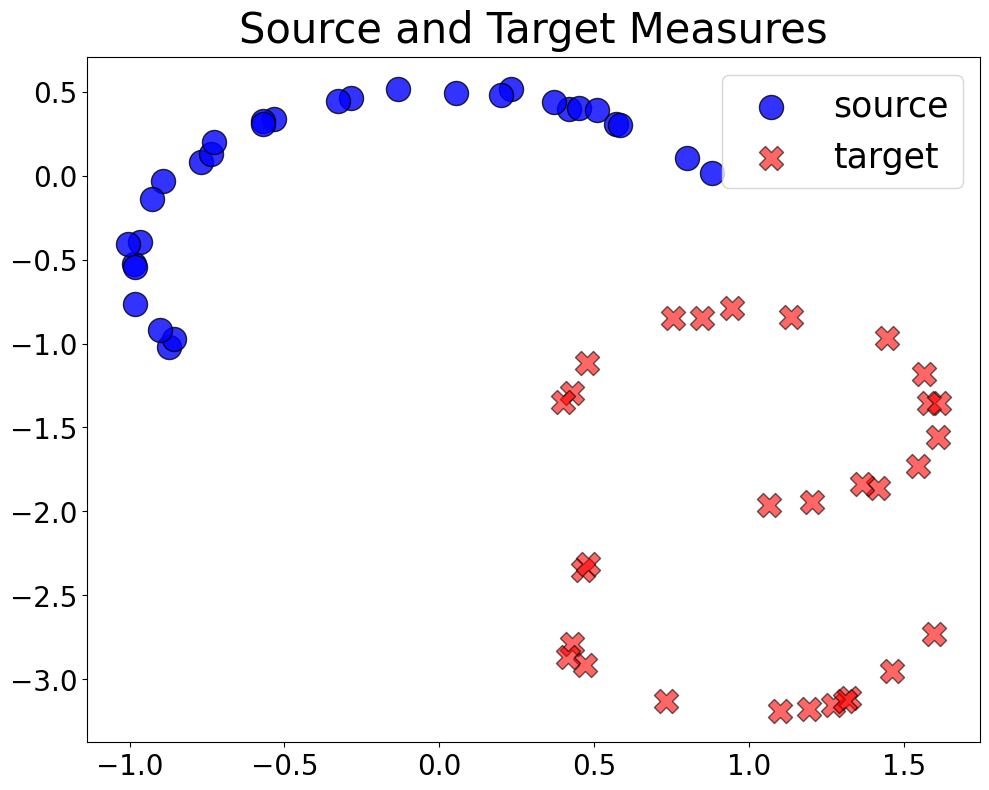

In [18]:
train_dataset, valid_dataset, dim_data = create_samplers(
    source_kwargs={
        "name": "moon",
        "theta_rotation": jnp.pi / 6,
        "mean": jnp.array([0.0, -0.5]),
        "noise": 0.02,
    },
    target_kwargs={
        "name": "s_curve",
        "scale": 0.6,
        "mean": jnp.array([1.0, -2.0]),
        "theta_rotation": jnp.pi / 2,
        "noise": 0.03,
    },
)

batch = {}
batch["source"] = next(train_dataset.source_iter)
batch["target"] = next(train_dataset.target_iter)
plot(batch=batch, num_points=30)

## Learning Maps

 We first try fitting a map without a Monge gap, minimizing only the fitting loss $\Delta$, recovering an arbitrary push-forward between $\mu$ and $\nu$. We then use the Monge gap to fit Monge maps that are optimal for the squared-Euclidean cost $c = \ell_2^2$ and the Euclidean cost $c = \ell_2$.

We use the standard {class}`~ott.solvers.nn.models.MLP`s to parameterize maps. For $c = \ell_2^2$, we use $\lambda_\mathrm{MG} = 1$ and for $c = \ell_2$ we use $\lambda_\mathrm{MG} = 2.5$. For all fittings, we use $\Delta = S_{\varepsilon, \ell_2^2}$, the {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` with the {class}`squared-Euclidean cost <ott.geometry.costs.SqEuclidean>`.

In [19]:
fitting_loss = lambda x, y: sinkhorn_divergence.sinkhorn_divergence(
    pointcloud.PointCloud, x, y, epsilon=0.2, cost_fn=costs.ElasticL1()
).divergence

In [20]:
def fit_map(
    cost_fn,
    title,
    num_train_iters=1000,
    regularizer_strength=1.0,
    regularizer_epsilon=0.1,
):
    dim_data = 2
    msg = (
        "without Monge gap"
        if title == "no_monge_gap"
        else f"with ${title}$ Monge gap"
    )
    # define the neural network that is our neural map
    model = models.MLP(
        dim_hidden=[128, 64, 64], is_potential=False, act_fn=nn.gelu
    )

    # define the optimizer to learn the neural map
    optimizer = optax.adam(learning_rate=1e-2)

    # define regularizer
    if cost_fn is None:
        regularizer = None
    else:
        regularizer = jax.tree_util.Partial(
            losses.monge_gap_from_samples,
            cost_fn=cost_fn,
            epsilon=regularizer_epsilon,
        )

    # define solver
    solver = map_estimator.MapEstimator(
        dim_data=dim_data,
        fitting_loss=fitting_loss,
        regularizer=regularizer,
        model=model,
        optimizer=optimizer,
        regularizer_strength=regularizer_strength,
        num_train_iters=num_train_iters,
        logging=True,
        valid_freq=50,
    )

    neural_state, _ = solver.train_map_estimator(
        trainloader_source=train_dataset.source_iter,
        trainloader_target=train_dataset.target_iter,
        validloader_source=valid_dataset.source_iter,
        validloader_target=valid_dataset.target_iter,
    )

    # plot the fitted map
    batch["mapped_source"] = neural_state.apply_fn(
        {"params": neural_state.params},
        batch["source"],
    )
    plot(
        batch=batch,
        num_points=50,
        title=r"Fitted map $\hat{T}_\theta$ " + msg,
    )

We can now examine how these maps vary, depending on whether the Monge gap was used or not.

 When fitting without a Monge gap, one recovers an arbitrary push-forward, which has no reason to be optimal for any cost.

100%|██████████| 100/100 [00:09<00:00, 10.41it/s, fitting_loss: nan, regularizer: not computed.]  


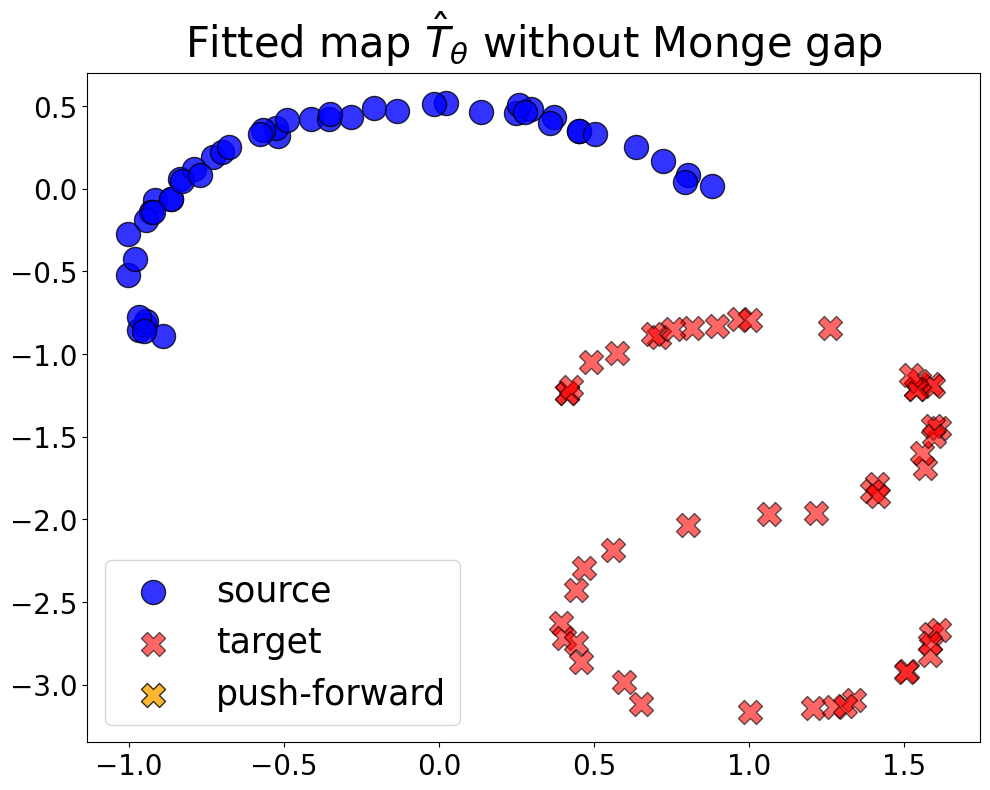

In [21]:
fit_map(None, "no_monge_gap", num_train_iters=100)

In [26]:
print(costs.Euclidean().pairwise)

<bound method Euclidean.pairwise of <ott.geometry.costs.Euclidean object at 0x2ce875d10>>


For the Monge gap with $c = \ell_2$, we obtain a "needle" alignment (without crossing lines) because $c$ is a distance: this is known as the Monge Mather shortening principle (see e.g. {cite}`villani:09`).

In [9]:
regularizer_epsilon = 0.1
fit_map(
    costs.Euclidean(),
    r"\ell_2",
    regularizer_epsilon=regularizer_epsilon,
    regularizer_strength=1.0,
)

 23%|██▎       | 226/1000 [00:20<01:10, 10.92it/s, fitting_loss: nan, regularizer: 1.2477.]   


KeyboardInterrupt: 

For $c = \ell_2^2$, we observe crossings when the sum of the squared diagonals of the quadrilateral induced by 4 points $(x_1, x_2, T(x_1), T(x_2))$ is lower than the sum of the squared sides. 

In [ ]:
regularizer_epsilon_sq = regularizer_epsilon**2
fit_map(
    costs.SqEuclidean(), r"\ell_2^2", regularizer_epsilon=regularizer_epsilon_sq
)

NameError: name 'regularizer_epsilon' is not defined